In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

import numpy as np
from utils import adata_train, adata_test

/ix/djishnu/alw399/envs/bee/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:275: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number
/ix/djishnu/alw399/envs/bee/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:275: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


In [3]:
from tqdm import tqdm
import pandas as pd

import celloracle as co
oracle = co.data.load_tutorial_oracle_object()

which: no R in (/ix/djishnu/alw399/envs/bee/bin:/ix/djishnu/alw399/envs/bee/bin:/ihome/crc/install/python/ondemand-jupyter-python3.10-2023.03/condabin:/ihome/crc/install/ondemand/code-server/code-server-4.5.1-linux-amd64/lib/vscode/bin/remote-cli:/ihome/crc/install/python/ondemand-jupyter-python3.10-2023.03/bin:/ihome/crc/install/ondemand/code-server/code-server-4.5.1-linux-amd64/bin:/ihome/crc/install/git/2.33.0/bin:/ihome/djishnu/alw399/.local/bin:/ihome/djishnu/alw399/bin:/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/ihome/crc/pipx/bin:/ihome/crc/install/gcc-8.2.0/bedtools/bedtools2-2.30.0/bin:/ihome/djishnu/alw399/.local/bin:/ihome/djishnu/alw399/bin:/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/ihome/crc/pipx/bin:/ihome/crc/pipx/bin:/ihome/crc/install/gcc-8.2.0/bedtools/bedtools2-2.30.0/bin:/ihome/djishnu/alw399/.local/bin:/ihome/djishnu/alw399/bin:/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/ihome/crc/pipx/bin:/ihome/crc/install/gcc-8.2.0/bedtools/b

In [4]:
import spaceoracle

so = spaceoracle.SpaceOracle(
    adata_train, 
    init_betas='ones', 
    max_epochs=25, 
    learning_rate=3e-4, 
    spatial_dim=64,
    batch_size=128,
    n_patches=2, n_heads=2, n_blocks=4, hidden_d=16
)


🌍️ Generating spatial maps: 100%|██████████| 9043/9043 [00:16<00:00, 536.54it/s]


In [5]:
import copy 

so.adata = copy.deepcopy(oracle.adata)
so.pcs, so.pca = so.perform_PCA(so.adata)
so.knn_imputation(so.adata, so.pcs)
so.gene2index = dict(zip(
                so.adata.var_names, 
                range(len(so.adata.var_names))
            ))


In [6]:
so.embedding_name = 'X_draw_graph_fa'
so.embedding = so.adata.obsm['X_draw_graph_fa']
so.cluster_column_name = 'louvain'

In [7]:
from celloracle.applications import Pseudotime_calculator

pt = Pseudotime_calculator(oracle_object=so)

In [8]:
# Instantiate pseudotime object using anndata object.
pt = Pseudotime_calculator(adata=so.adata,
                           obsm_key=so.embedding_name, # Dimensional reduction data name
                           cluster_column_name=so.cluster_column_name # Clustering data name
                           )

45


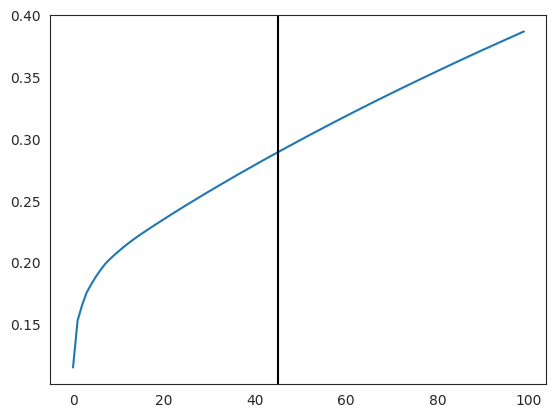

In [9]:
# Select important PCs
%matplotlib inline
import matplotlib.pyplot as plt
import scanpy as sc 

plt.plot(np.cumsum(so.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(so.pca.explained_variance_ratio_))>0.002))[0][0]
print(n_comps)

plt.axvline(n_comps, c="k")
plt.show()
n_comps = min(n_comps, 50)

In [10]:
n_cell = so.adata.shape[0]
print(f"cell number is :{n_cell}")

k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

cell number is :2671
Auto-selected k is :66


In [11]:
so.knn_imputation(so.adata, so.pcs, n_pca_dims=n_comps, k=k, balanced=False, b_sight=k*8,
                      b_maxl=k*4, n_jobs=4)

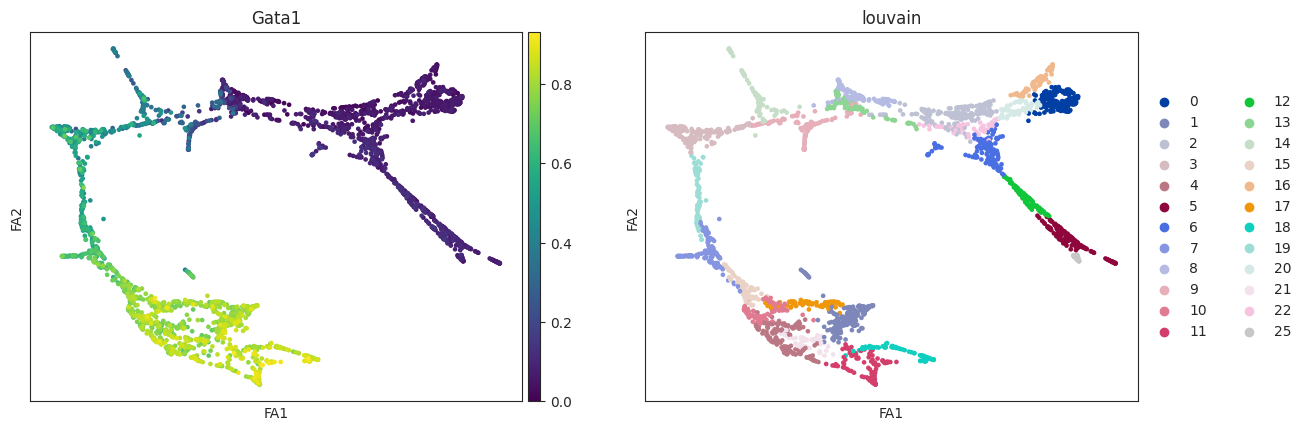

In [12]:
# Check gene expression 
import scanpy as sc 

goi = "Gata1"
sc.pl.draw_graph(so.adata, color=[goi, so.cluster_column_name],
                 layer="imputed_count", use_raw=False, cmap="viridis")

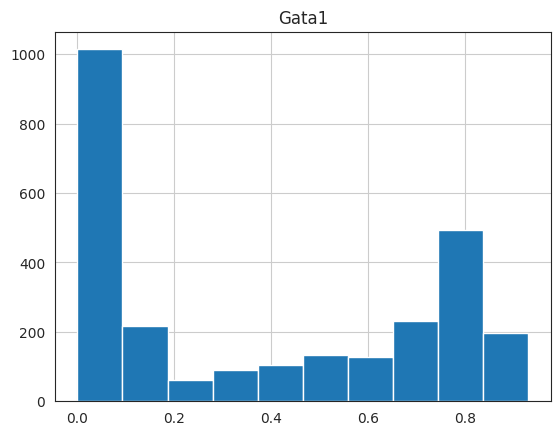

In [13]:
# Plot gene expression in histogram
sc.get.obs_df(so.adata, keys=[goi], layer="imputed_count").hist()
plt.show()

In [14]:
# need cell oracle coef_matrix

links = co.data.load_tutorial_links_object()
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10, 
                              use_cluster_specific_TFdict=True)

  0%|          | 0/24 [00:00<?, ?it/s]

In [15]:
# Construct coef for each cell (gene x gene x cell)
coef_matrix = []

for cluster in list(so.adata.obs['louvain_annot']):
    cell_coef = oracle.coef_matrix_per_cluster[cluster]
    coef_matrix.append(cell_coef)

coef_matrix = np.array(coef_matrix)
coef_matrix.shape

(2671, 1999, 1999)

In [16]:
coef_matrix.shape, so.adata.to_df().shape
# del(adata_test)

((2671, 1999, 1999), (2671, 1999))

In [17]:
list(so.adata.to_df().columns).index('Gata1')

739

In [18]:
# Doing this manually because coefs are different
import torch

# coef_matrix = so.get_coef_matrix(so.adata.copy())
coef_matrix = np.transpose(coef_matrix, axes = (2, 1, 0))
coef_matrix = torch.tensor(coef_matrix, dtype=torch.floa162)

perturbed_matrix = so.perturb(so.adata.to_df().values.astype(np.float16), coef_matrix, gex_dict = {739 : 0.0}, n_propagation=3)
so.adata.layers['delta_X'] = perturbed_matrix - so.adata.layers["imputed_count"]

# so.simulate_shift(gex_dict = {'Gata1': 0.0})

: 

: 

In [ ]:
oracle.simulate_shift(perturb_condition={goi: 0.0},
                      n_propagation=3)

In [ ]:
np.allclose(oracle.adata.layers['delta_X'], so.adata.layers['delta_X'])

False

In [ ]:
np.allclose(so.adata.layers['normalized_count'], so.adata.layers['delta_X'])

False

In [ ]:
oracle.adata.layers['delta_X']

array([[-2.01290315e-05,  1.59353567e-02,  4.95181210e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.41063066e-08,  4.04961339e-05,  5.87056623e-08, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.84684868e-05, -2.19007477e-04, -2.14351304e-05, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-2.21772984e-05,  1.75568885e-02,  5.45569291e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.18341445e-08,  5.41124981e-06, -1.30747380e-06, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 5.20560093e-06, -3.38173873e-06, -1.40611081e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [ ]:
so.adata.layers['delta_X']

array([[-0.11678527, -0.4800138 , -0.26922702, ..., -0.3618107 ,
        -0.24910285, -0.05067114],
       [-0.3129289 , -0.23153887,  0.02236757, ..., -0.06550126,
        -0.0381675 , -0.083397  ],
       [ 0.11160257,  0.0851987 ,  0.16548423, ...,  0.16659931,
         0.20920351, -0.00349727],
       ...,
       [-0.07842101,  0.97939468, -0.28102156, ..., -0.20759812,
        -0.33377604,  0.        ],
       [ 0.54457059,  0.25822047,  0.74441629, ..., -0.163943  ,
        -0.0168678 , -0.04024379],
       [-0.29189424, -0.00712465,  0.04547484, ..., -0.16904698,
        -0.0947897 ,  0.27128086]])

In [ ]:
so.adata.layers['normalized_count']

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.53467   , 0.53467   , ..., 0.        , 0.        ,
        0.        ],
       [0.36214313, 0.836907  , 0.36214313, ..., 0.36214313, 0.6274395 ,
        0.        ],
       ...,
       [0.        , 1.6144475 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.0154102 , 1.0154102 , 1.3696971 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.818894  , 0.27535453, ..., 0.        , 0.27535453,
        0.27535453]], dtype=float32)

In [ ]:
so.adata.layers['delta_X'] = so.adata.layers['delta_X'].astype(np.float32)

so.estimate_transition_prob(n_neighbors=200,
                                knn_random=True, 
                                sampled_fraction=1)

ValueError: Buffer dtype mismatch, expected 'double' but got 'float'

In [ ]:
so.calculate_embedding_shift(sigma_corr=0.05)

/ix/djishnu/alw399/envs/bee/lib/python3.9/site-packages/numpy/linalg/linalg.py:2582: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
/ix/djishnu/alw399/envs/bee/lib/python3.9/site-packages/numpy/linalg/linalg.py:2583: RuntimeWarning: overflow encountered in reduce
  return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))


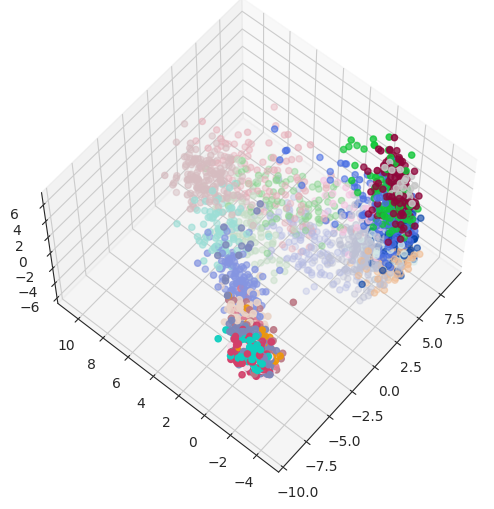

In [ ]:
so.plot_pca()

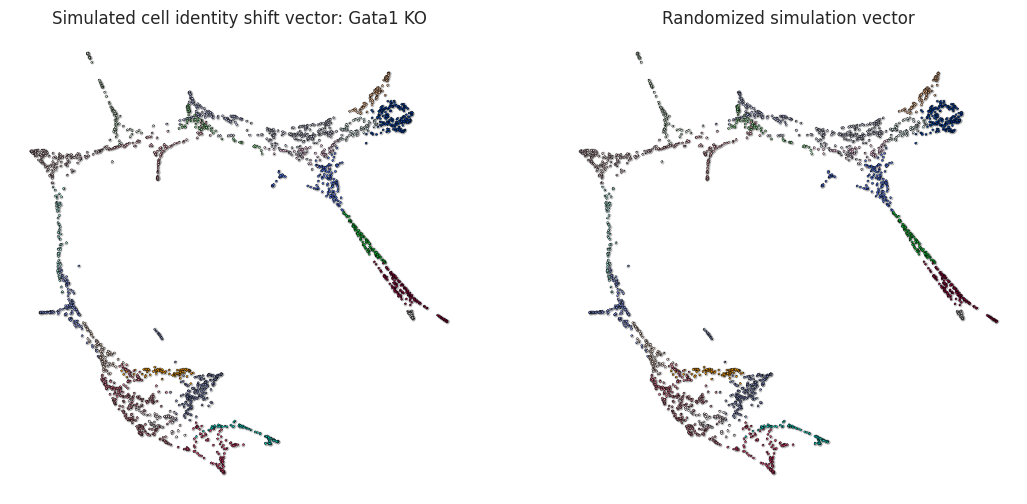

In [ ]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale = 25
# Show quiver plot
so.plot_quiver(scale=scale, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
so.plot_quiver_random(scale=scale, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

In [ ]:
# n_grid = 40 is a good starting value.
n_grid = 40 
so.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)

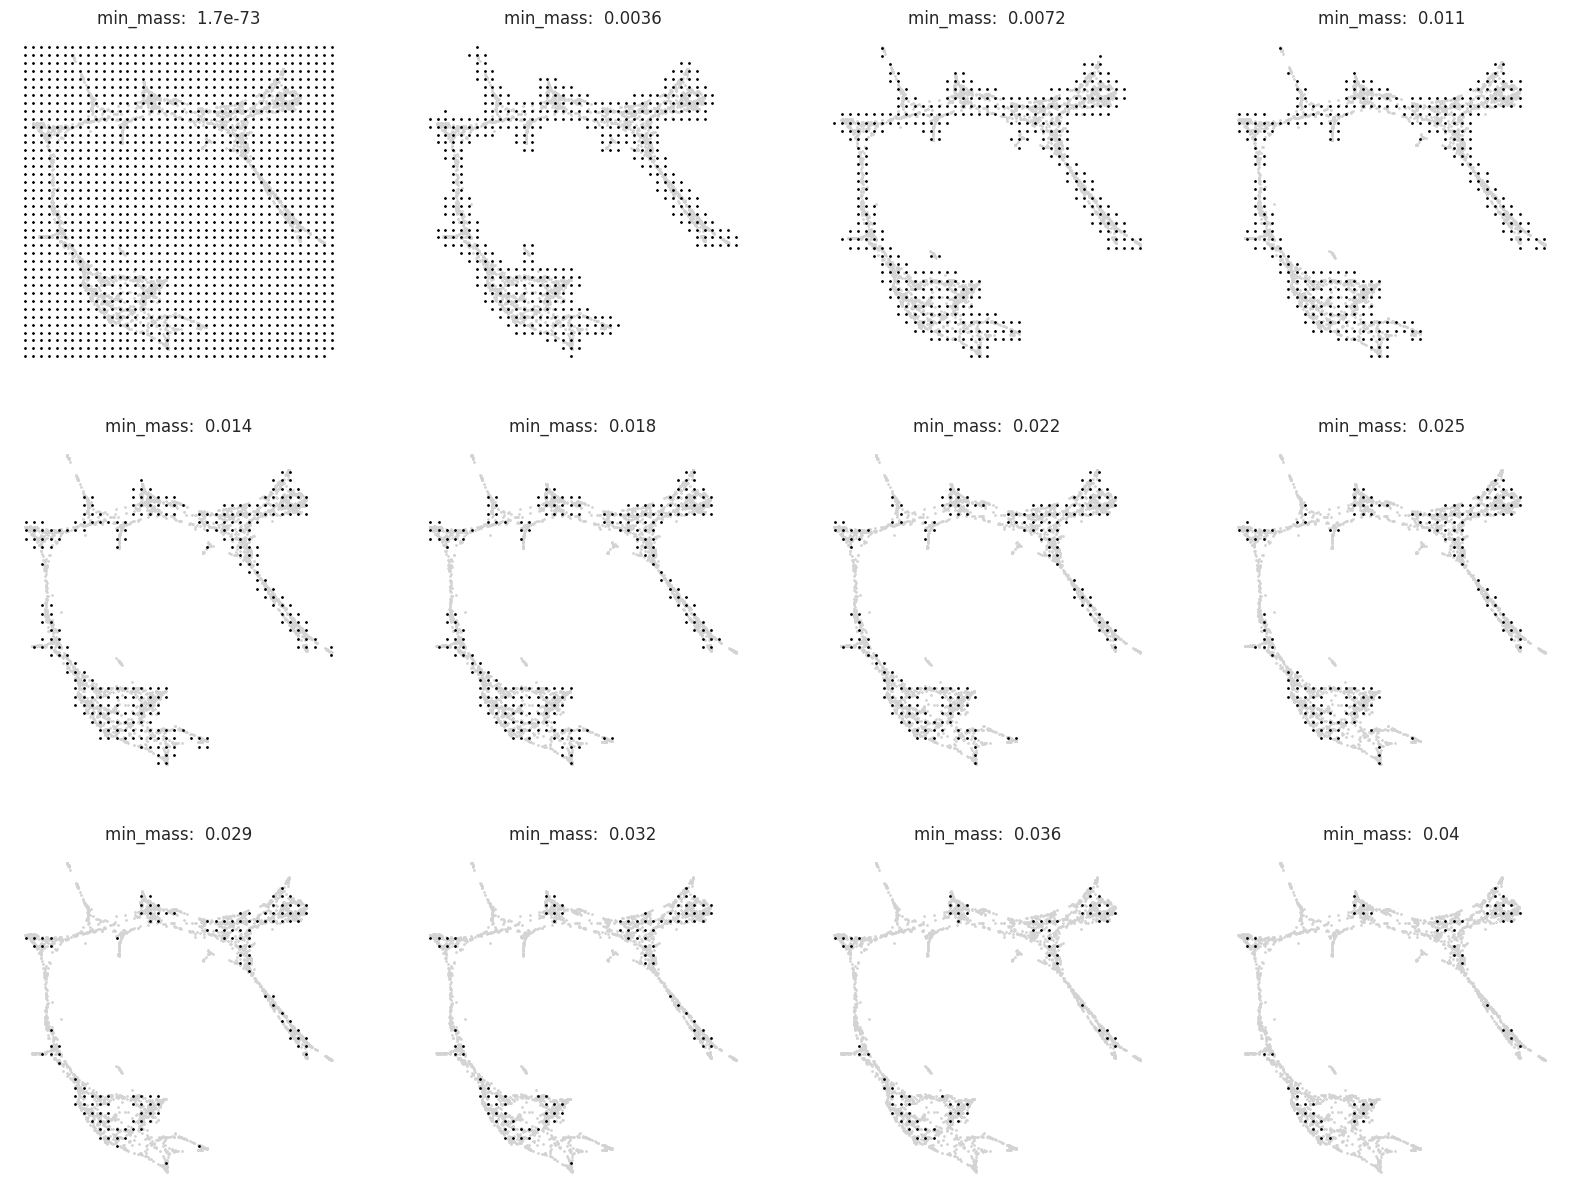

In [ ]:
# Search for best min_mass.
so.suggest_mass_thresholds(n_suggestion=12)

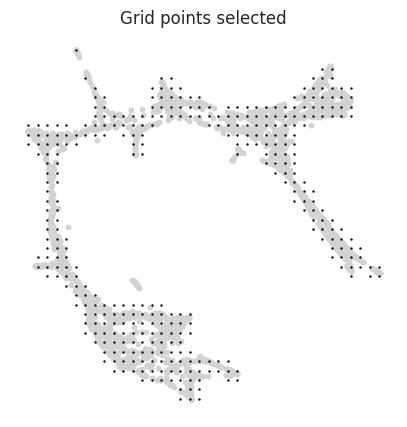

In [ ]:
min_mass = 0.01
so.calculate_mass_filter(min_mass=min_mass, plot=True)

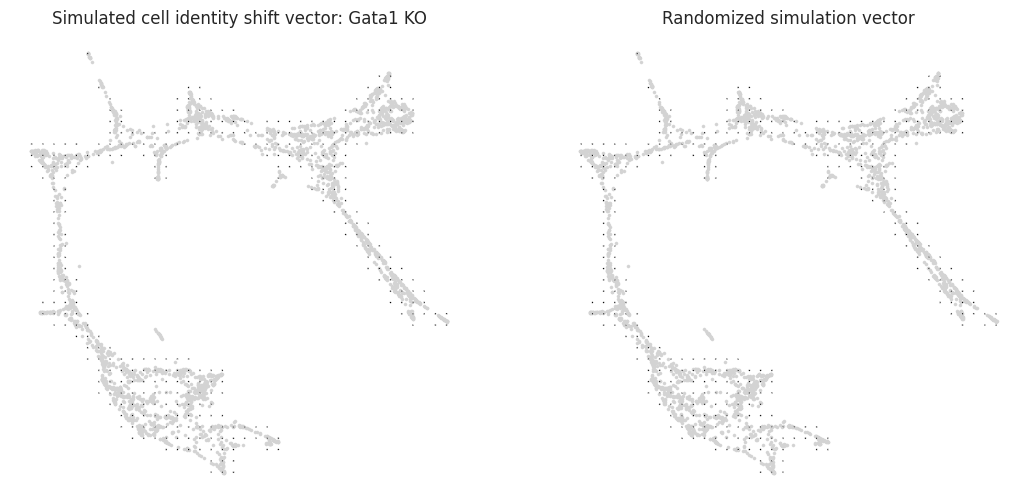

In [ ]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale_simulation = 0.5
# Show quiver plot
so.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
so.plot_simulation_flow_random_on_grid(scale=scale_simulation, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

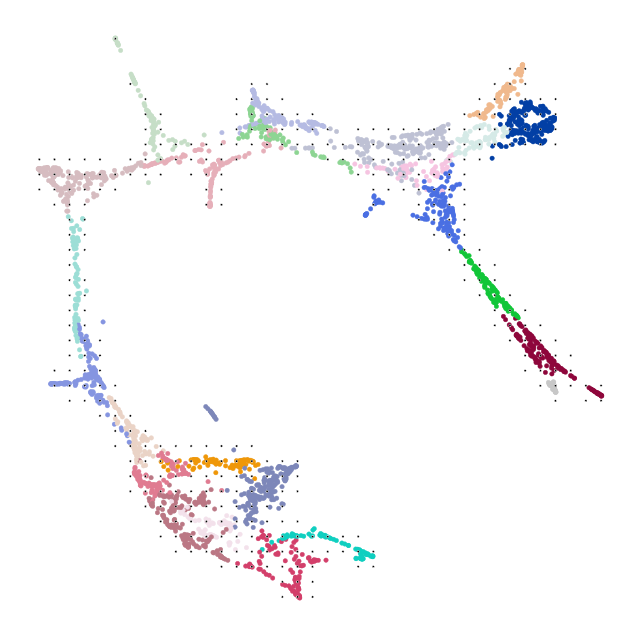

In [ ]:
# Plot vector field with cell cluster 
fig, ax = plt.subplots(figsize=[8, 8])

so.plot_cluster_whole(ax=ax, s=10)
so.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax, show_background=False)